In [2]:
# Menganalisis tren dan pola waktu kejadian gempa bumi menggunakan metode time series: ARIMA, Prophet, dan LSTM.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("seismic_gap_features_clustered.csv")

# Pastikan kolom date bertipe datetime
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# Hitung jumlah gempa per tahun per cluster
cluster_counts = {}

for cluster_id in sorted(df['cluster'].unique()):
    # Buat dataframe dengan jumlah gempa per tahun
    yearly_count = (
        df[df['cluster'] == cluster_id]
        .groupby('year')
        .size()
        .rename("count")
        .reset_index()
    )

    # Ubah ke datetime index berbasis 31 Desember tiap tahun (biar Prophet juga bisa)
    yearly_count['ds'] = pd.to_datetime(yearly_count['year'].astype(str) + "-12-31")
    yearly_count = yearly_count.set_index('ds').asfreq('Y').fillna(0)

    cluster_counts[cluster_id] = yearly_count[['count']]



C:\Users\fmoch\AppData\Local\Temp\ipykernel_19672\3011330191.py:26: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_count = yearly_count.set_index('ds').asfreq('Y').fillna(0)
C:\Users\fmoch\AppData\Local\Temp\ipykernel_19672\3011330191.py:26: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_count = yearly_count.set_index('ds').asfreq('Y').fillna(0)
C:\Users\fmoch\AppData\Local\Temp\ipykernel_19672\3011330191.py:26: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_count = yearly_count.set_index('ds').asfreq('Y').fillna(0)
C:\Users\fmoch\AppData\Local\Temp\ipykernel_19672\3011330191.py:26: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_count = yearly_count.set_index('ds').asfreq('Y').fillna(0)
C:\Users\fmoch\AppData\Local\Temp\ipykernel_19672\3011330191

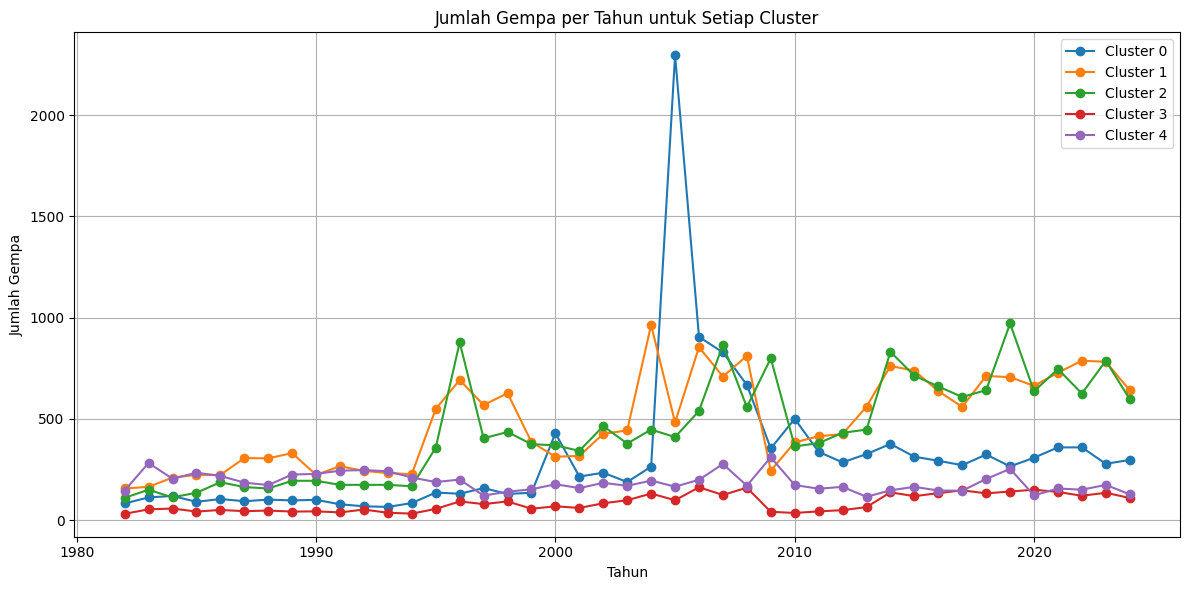

In [2]:
#jumlah gempa tiap cluster 

# Inisialisasi figure
plt.figure(figsize=(12, 6))

# Loop untuk masing-masing cluster dan plot
for cluster_id in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster_id]
    yearly_counts = cluster_data.groupby('year').size()
    plt.plot(yearly_counts.index, yearly_counts.values, marker='o', label=f'Cluster {cluster_id}')

# Label dan judul
plt.title('Jumlah Gempa per Tahun untuk Setiap Cluster')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Gempa')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

A. Forecasting dengan ARIMA


In [3]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


ts = cluster_counts[0]

In [4]:
from pmdarima import auto_arima
import traceback
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 1. Load dataset
df = pd.read_csv("seismic_gap_features_clustered.csv")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# 2. Rata rata mag per tahun per cluster
#count_df = df.groupby(['year', 'cluster']).size().reset_index(name='count')
mean_mag_df = df.groupby(['year', 'cluster'])['mag'].mean().reset_index(name='avg_mag')

# 3. Inisialisasi tempat penyimpanan hasil
results = {}

# 4. Iterasi untuk setiap cluster
for cluster_id in sorted(mean_mag_df['cluster'].unique()):
    print(f"\n🔎 Memproses Cluster {cluster_id}...")

    try:
        # Filter dan sort data untuk cluster saat ini
        cluster_data = mean_mag_df[mean_mag_df['cluster'] == cluster_id].sort_values(by='year')

        # Buat time series dengan index berupa period tahunan
        cluster_ts = pd.Series(cluster_data['avg_mag'].values, 
                       index=pd.period_range(start=str(cluster_data['year'].min()), 
                                             end=str(cluster_data['year'].max()), 
                                             freq='Y'))
       
        # 5. Jalankan auto_arima untuk mencari model terbaik
        model = auto_arima(cluster_ts,
                           seasonal=False,        # Non-musiman (bukan data bulanan/kuartalan)
                           stepwise=True,         # Stepwise search (lebih cepat)
                           trace=True,            # Tampilkan percobaan kombinasi order
                           suppress_warnings=True,
                           error_action='ignore') # Abaikan error kecil agar tidak menghentikan proses

        # Simpan hasil
        results[cluster_id] = {
            'model': model,
            'order': model.order,
            'aic': model.aic(),
            'bic': model.bic(),
            'summary': model.summary()
        }

        print(f"✅ Cluster {cluster_id} → ARIMA{model.order} | AIC: {model.aic():.2f} | BIC: {model.bic():.2f}")

    except Exception as e:
        print(f"❌ Gagal memproses Cluster {cluster_id}: {e}")
        traceback.print_exc()
        continue
    
with open("arima_summary.txt", "w", encoding="utf-8") as f:
    for cluster_id, result in results.items():
        f.write(f"📊 Cluster {cluster_id}\n")
        f.write(result["summary"].as_text())
        f.write("\n\n")





🔎 Memproses Cluster 0...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=12.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-88.458, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-86.745, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-86.777, Time=2.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-90.457, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=7.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 21.906 seconds
✅ Cluster 0 → ARIMA(0, 1, 0) | AIC: -90.46 | BIC: -88.72

🔎 Memproses Cluster 1...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-79.522, Time=10.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=250.759, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=3.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-81.386, Time=8.13 sec
 ARIMA(0,0,2)(0,0,0)[0]   

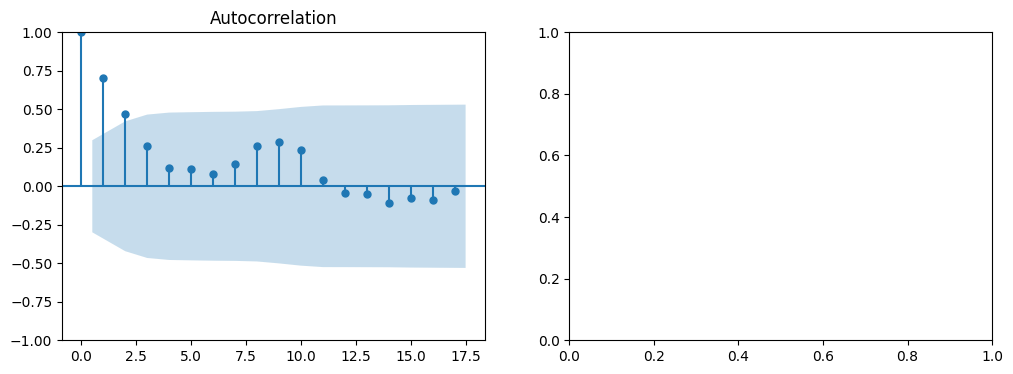

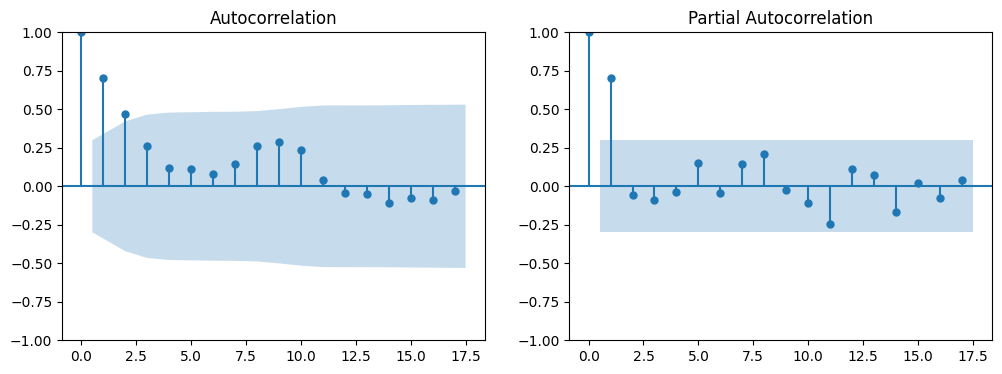

Text(0.5, 1.0, 'ACF - Cluster 0')

Text(0.5, 1.0, 'PACF - Cluster 0')

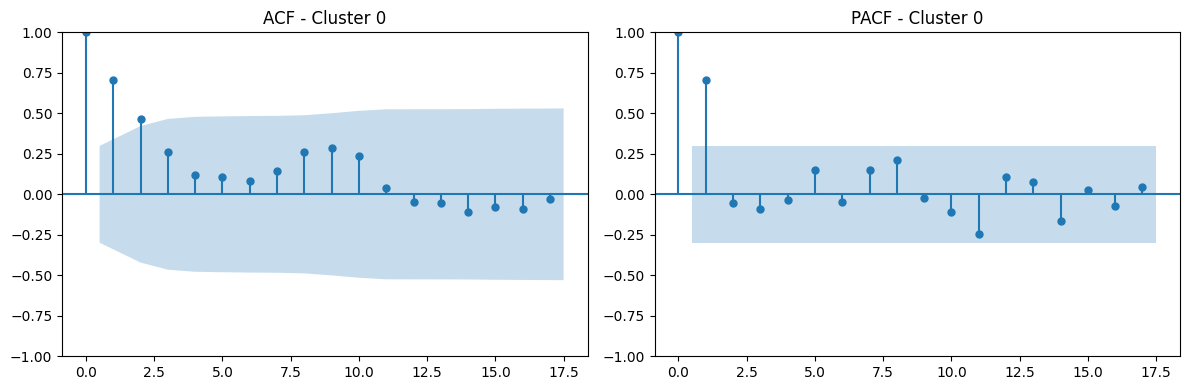

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   43
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  46.228
Date:                Sun, 20 Jul 2025   AIC                            -90.457
Time:                        14:29:49   BIC                            -88.719
Sample:                    12-31-1982   HQIC                           -89.820
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0065      0.001      7.840      0.000       0.005       0.008
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                34.07
Prob(Q):                              0.59   Pr

<Axes: >

<Axes: >

Text(0.5, 1.0, 'ARIMA Forecast - Cluster 0')

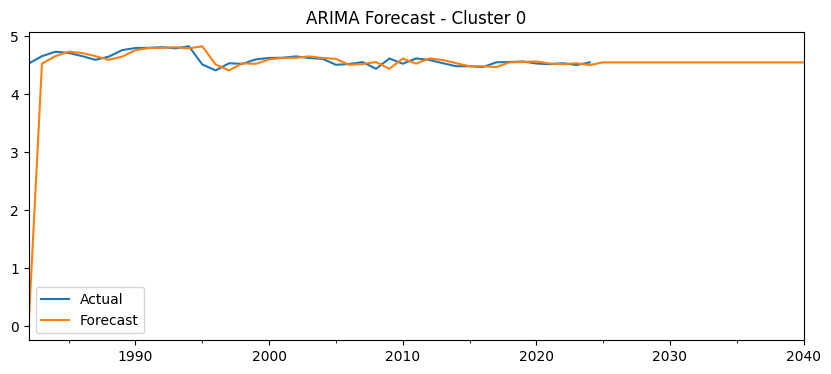

<Axes: ylabel='None'>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Residuals - Cluster 0')

Text(0.5, 1.0, 'Residual Distribution - Cluster 0')

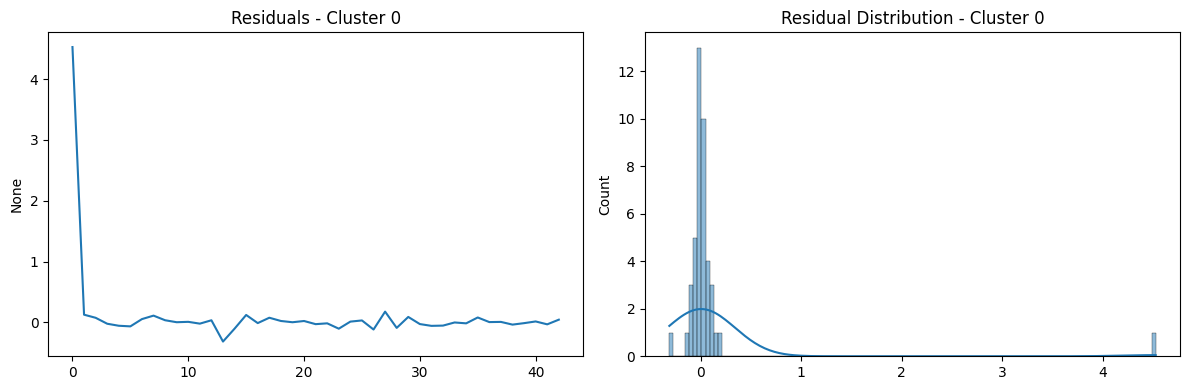

In [11]:
# --- Ambil data magnitudo untuk Cluster 0 ---

cluster_id = 0
cluster_data = mean_mag_df[mean_mag_df['cluster'] == cluster_id].sort_values(by='year')
ts = pd.Series(cluster_data['avg_mag'].values, 
               index=pd.period_range(start=str(cluster_data['year'].min()), 
                                     end=str(cluster_data['year'].max()), freq='Y'))

# --- ACF & PACF ---
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(ts, ax=ax[0])
plot_pacf(ts, ax=ax[1])
ax[0].set_title(f"ACF - Cluster {cluster_id}")
ax[1].set_title(f"PACF - Cluster {cluster_id}")
plt.tight_layout()
plt.show()

# --- ARIMA Fit & Forecast ---
model = ARIMA(ts, order=(0, 1, 0))  # atau ganti dengan results[cluster_id]['order']
fit = model.fit()
print(fit.summary())

forecast_index = pd.period_range(start=ts.index[0], end='2040', freq='Y')
pred = fit.predict(start=forecast_index[0], end=forecast_index[-1], typ='levels')

ts.plot(label="Actual", figsize=(10, 4))
pred.plot(label="Forecast")
plt.title(f"ARIMA Forecast - Cluster {cluster_id}")
plt.legend()
plt.show()

# --- Residual Diagnostic ---
resid = fit.resid
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(x=range(len(resid)), y=resid, ax=ax[0])
sns.histplot(resid, kde=True, ax=ax[1])
ax[0].set_title(f"Residuals - Cluster {cluster_id}")
ax[1].set_title(f"Residual Distribution - Cluster {cluster_id}")
plt.tight_layout()
plt.show()


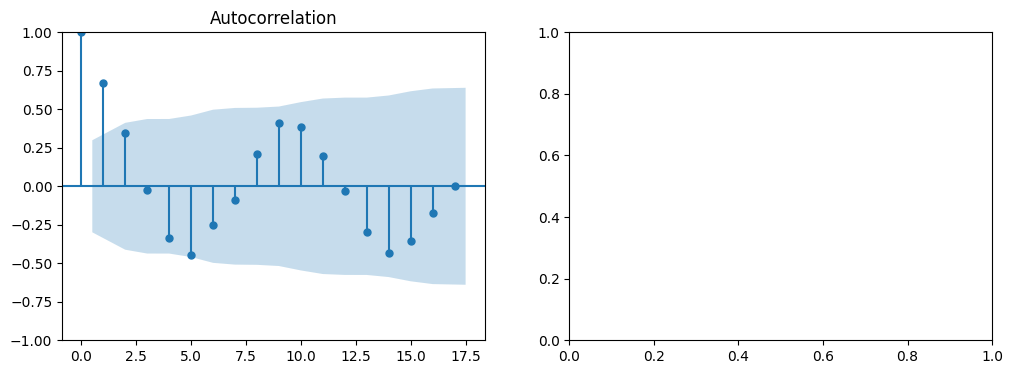

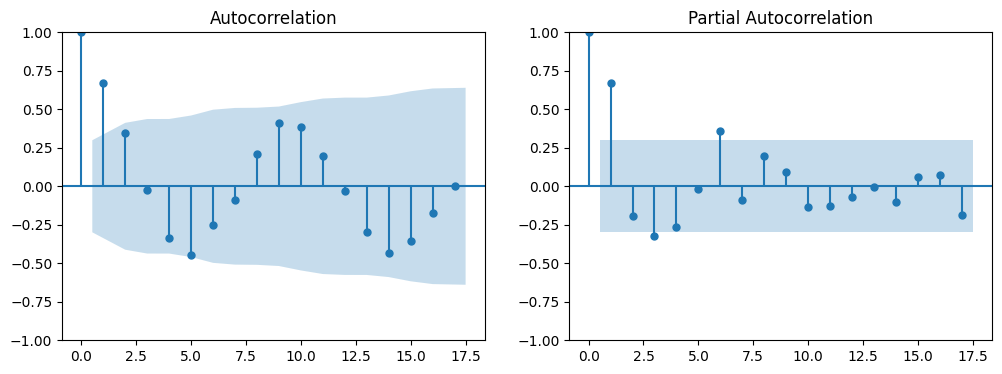

Text(0.5, 1.0, 'ACF - Cluster 1')

Text(0.5, 1.0, 'PACF - Cluster 1')

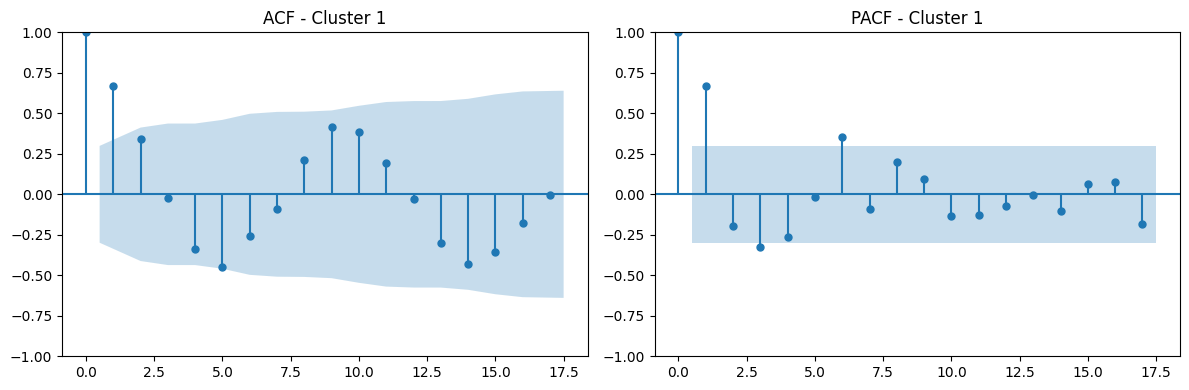

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   43
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  47.199
Date:                Sun, 20 Jul 2025   AIC                            -90.397
Time:                        14:32:31   BIC                            -86.922
Sample:                    12-31-1982   HQIC                           -89.123
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0094      0.218     -0.043      0.966      -0.437       0.418
sigma2         0.0062      0.001      7.733      0.000       0.005       0.008
Ljung-Box (L1) (Q):                   0.00   Jarque-

<Axes: >

<Axes: >

Text(0.5, 1.0, 'ARIMA Forecast - Cluster 1')

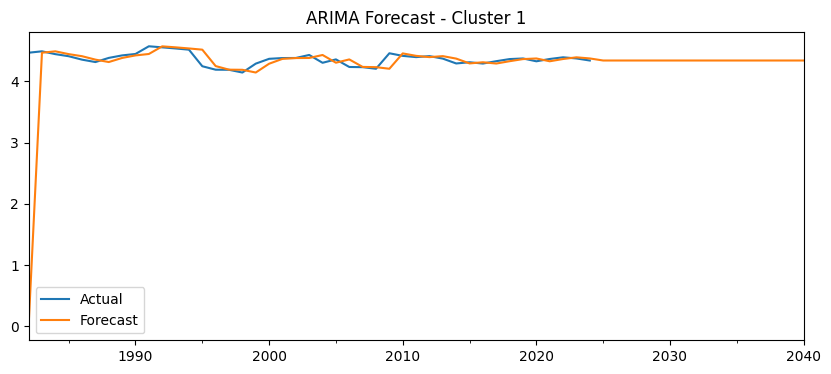

<Axes: ylabel='None'>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Residuals - Cluster 1')

Text(0.5, 1.0, 'Residual Distribution - Cluster 1')

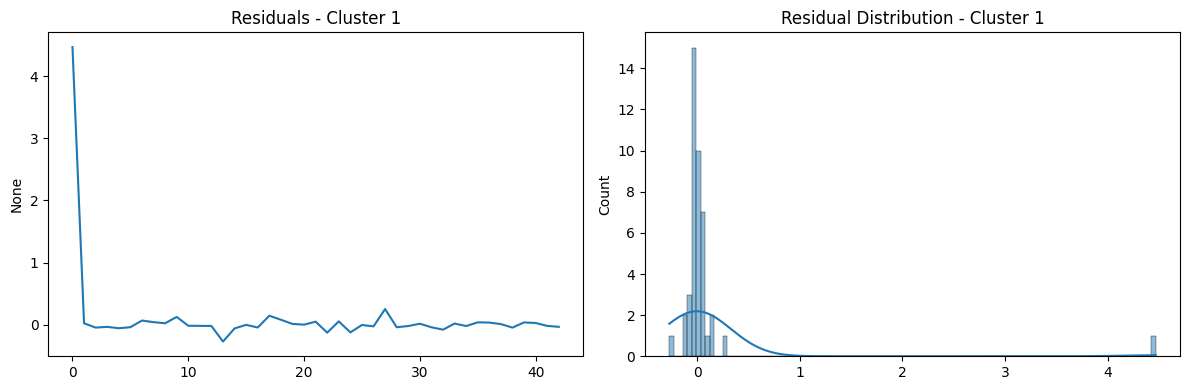

In [12]:
# --- Ambil data magnitudo untuk Cluster 1 ---

cluster_id = 1
cluster_data = mean_mag_df[mean_mag_df['cluster'] == cluster_id].sort_values(by='year')
ts = pd.Series(cluster_data['avg_mag'].values, 
               index=pd.period_range(start=str(cluster_data['year'].min()), 
                                     end=str(cluster_data['year'].max()), freq='Y'))

# --- ACF & PACF ---
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(ts, ax=ax[0])
plot_pacf(ts, ax=ax[1])
ax[0].set_title(f"ACF - Cluster {cluster_id}")
ax[1].set_title(f"PACF - Cluster {cluster_id}")
plt.tight_layout()
plt.show()

# --- ARIMA Fit & Forecast ---
model = ARIMA(ts, order=(1, 1, 0))  # atau ganti dengan results[cluster_id]['order']
fit = model.fit()
print(fit.summary())

forecast_index = pd.period_range(start=ts.index[0], end='2040', freq='Y')
pred = fit.predict(start=forecast_index[0], end=forecast_index[-1], typ='levels')

ts.plot(label="Actual", figsize=(10, 4))
pred.plot(label="Forecast")
plt.title(f"ARIMA Forecast - Cluster {cluster_id}")
plt.legend()
plt.show()

# --- Residual Diagnostic ---
resid = fit.resid
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(x=range(len(resid)), y=resid, ax=ax[0])
sns.histplot(resid, kde=True, ax=ax[1])
ax[0].set_title(f"Residuals - Cluster {cluster_id}")
ax[1].set_title(f"Residual Distribution - Cluster {cluster_id}")
plt.tight_layout()
plt.show()


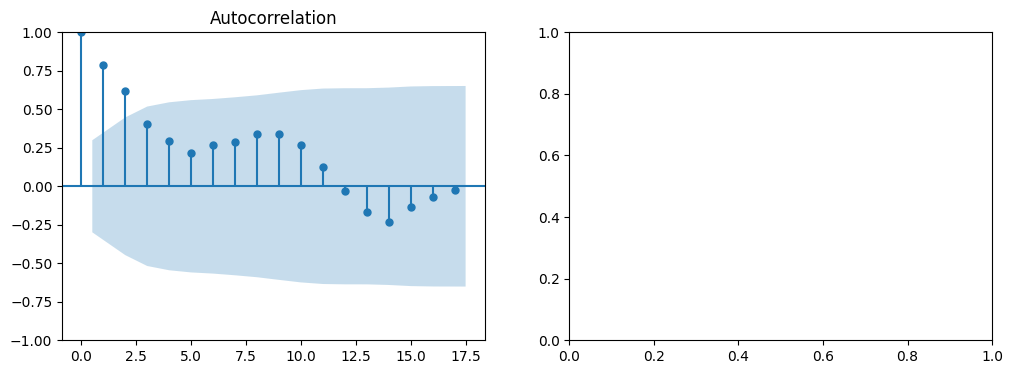

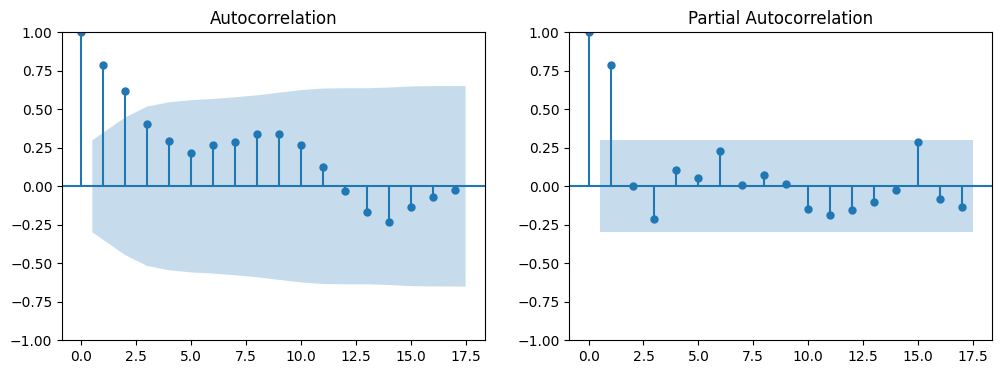

Text(0.5, 1.0, 'ACF - Cluster 2')

Text(0.5, 1.0, 'PACF - Cluster 2')

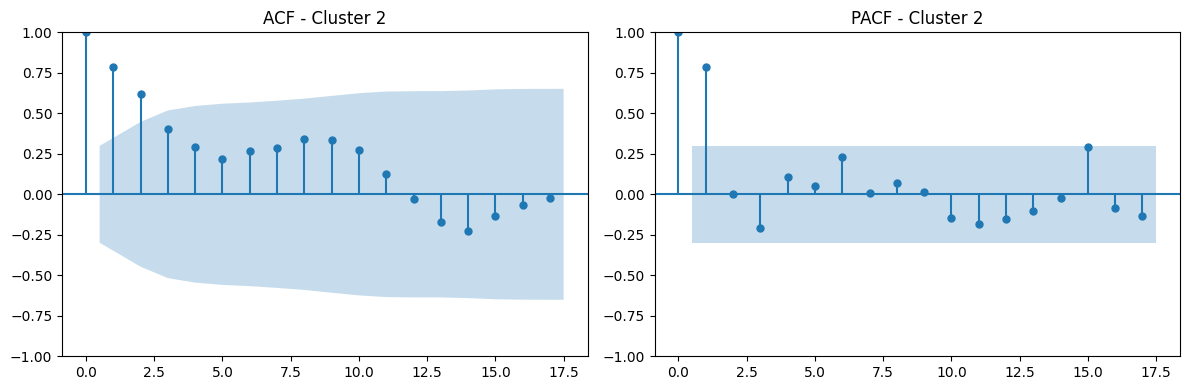

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   43
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  50.267
Date:                Sun, 20 Jul 2025   AIC                            -98.533
Time:                        14:32:41   BIC                            -96.795
Sample:                    12-31-1982   HQIC                           -97.896
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0053      0.000     11.112      0.000       0.004       0.006
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):               171.18
Prob(Q):                              0.34   Pr

<Axes: >

<Axes: >

Text(0.5, 1.0, 'ARIMA Forecast - Cluster 2')

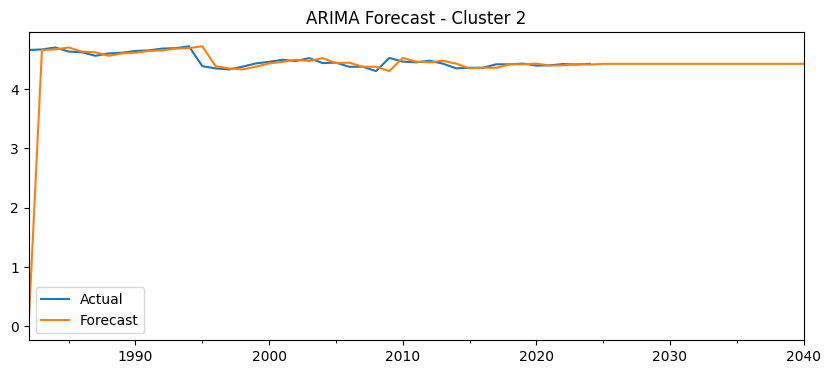

<Axes: ylabel='None'>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Residuals - Cluster 2')

Text(0.5, 1.0, 'Residual Distribution - Cluster 2')

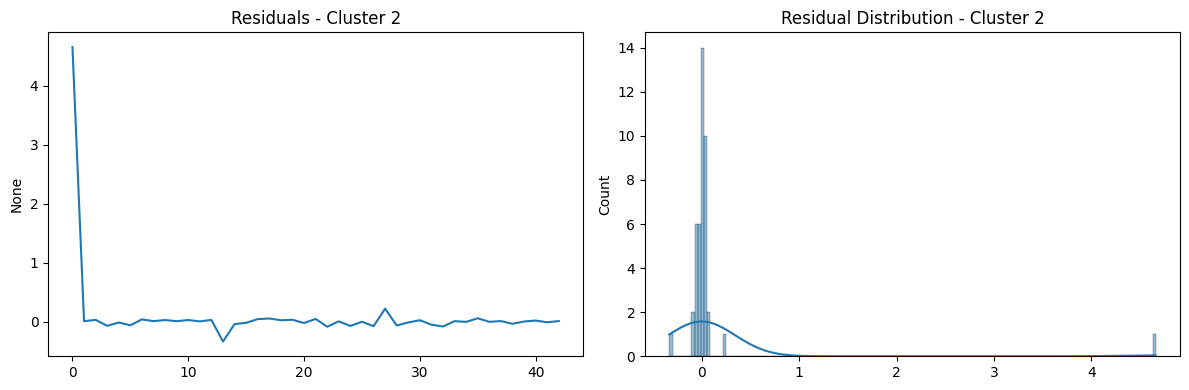

In [13]:
# --- Ambil data magnitudo untuk Cluster 2 ---

cluster_id = 2
cluster_data = mean_mag_df[mean_mag_df['cluster'] == cluster_id].sort_values(by='year')
ts = pd.Series(cluster_data['avg_mag'].values, 
               index=pd.period_range(start=str(cluster_data['year'].min()), 
                                     end=str(cluster_data['year'].max()), freq='Y'))

# --- ACF & PACF ---
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(ts, ax=ax[0])
plot_pacf(ts, ax=ax[1])
ax[0].set_title(f"ACF - Cluster {cluster_id}")
ax[1].set_title(f"PACF - Cluster {cluster_id}")
plt.tight_layout()
plt.show()

# --- ARIMA Fit & Forecast ---
model = ARIMA(ts, order=(0, 1, 0))  # atau ganti dengan results[cluster_id]['order']
fit = model.fit()
print(fit.summary())

forecast_index = pd.period_range(start=ts.index[0], end='2040', freq='Y')
pred = fit.predict(start=forecast_index[0], end=forecast_index[-1], typ='levels')

ts.plot(label="Actual", figsize=(10, 4))
pred.plot(label="Forecast")
plt.title(f"ARIMA Forecast - Cluster {cluster_id}")
plt.legend()
plt.show()

# --- Residual Diagnostic ---
resid = fit.resid
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(x=range(len(resid)), y=resid, ax=ax[0])
sns.histplot(resid, kde=True, ax=ax[1])
ax[0].set_title(f"Residuals - Cluster {cluster_id}")
ax[1].set_title(f"Residual Distribution - Cluster {cluster_id}")
plt.tight_layout()
plt.show()


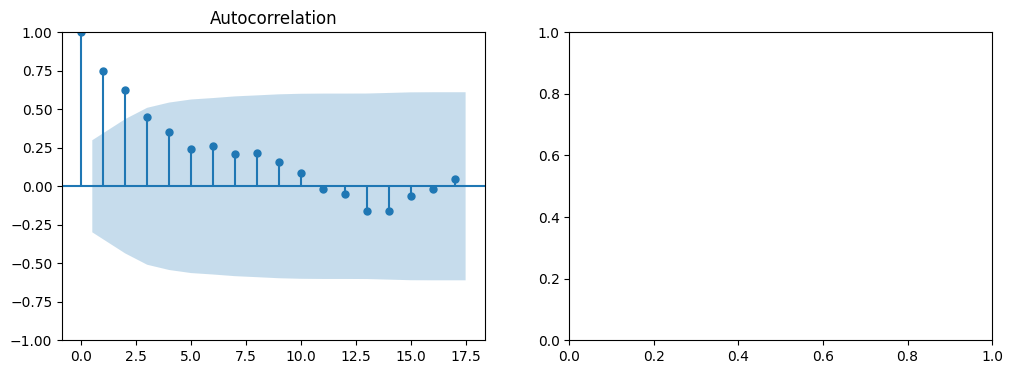

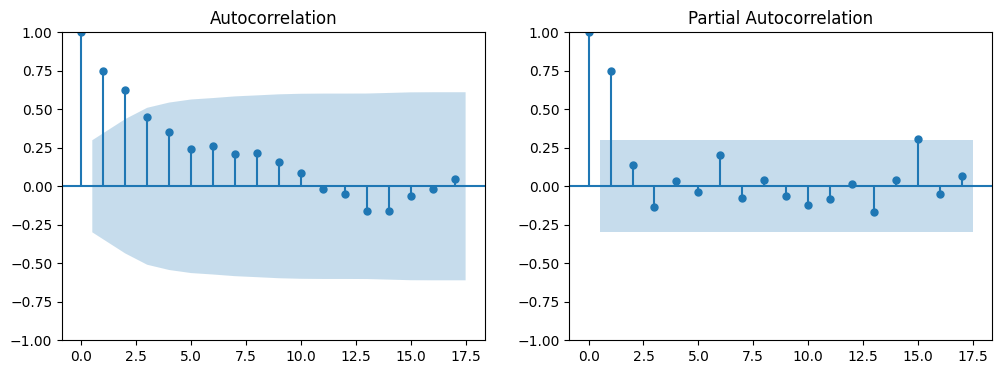

Text(0.5, 1.0, 'ACF - Cluster 3')

Text(0.5, 1.0, 'PACF - Cluster 3')

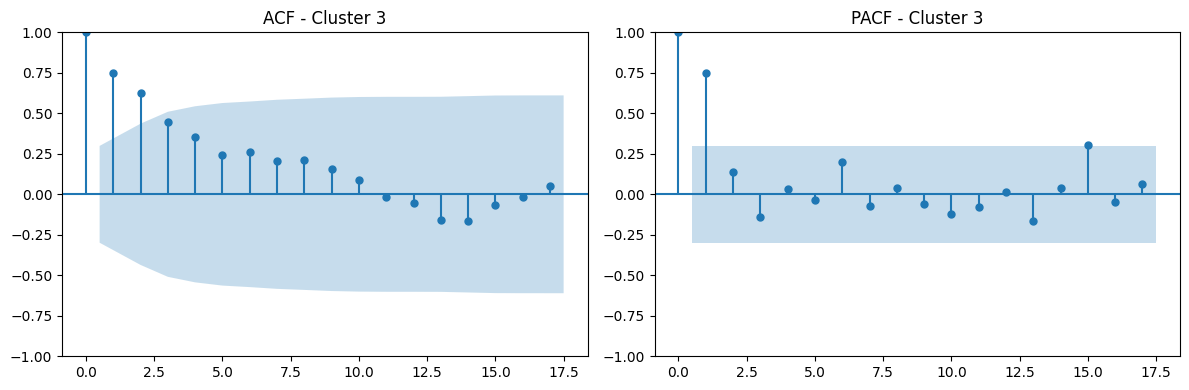

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   43
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  23.262
Date:                Sun, 20 Jul 2025   AIC                            -44.523
Time:                        14:32:51   BIC                            -42.786
Sample:                    12-31-1982   HQIC                           -43.886
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0193      0.002      8.608      0.000       0.015       0.024
Ljung-Box (L1) (Q):                   1.33   Jarque-Bera (JB):                66.02
Prob(Q):                              0.25   Pr

<Axes: >

<Axes: >

Text(0.5, 1.0, 'ARIMA Forecast - Cluster 3')

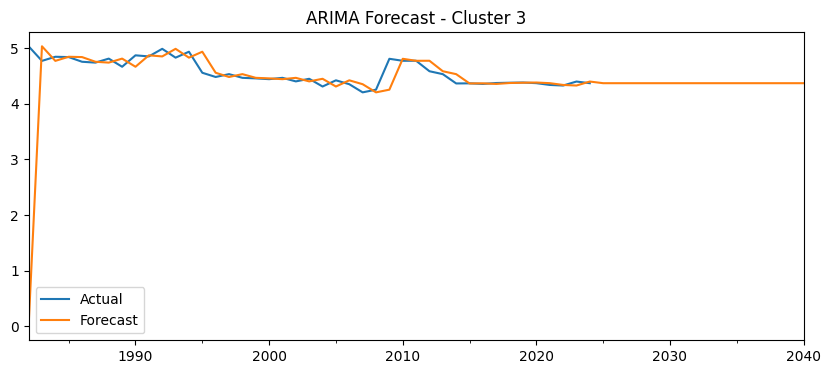

<Axes: ylabel='None'>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Residuals - Cluster 3')

Text(0.5, 1.0, 'Residual Distribution - Cluster 3')

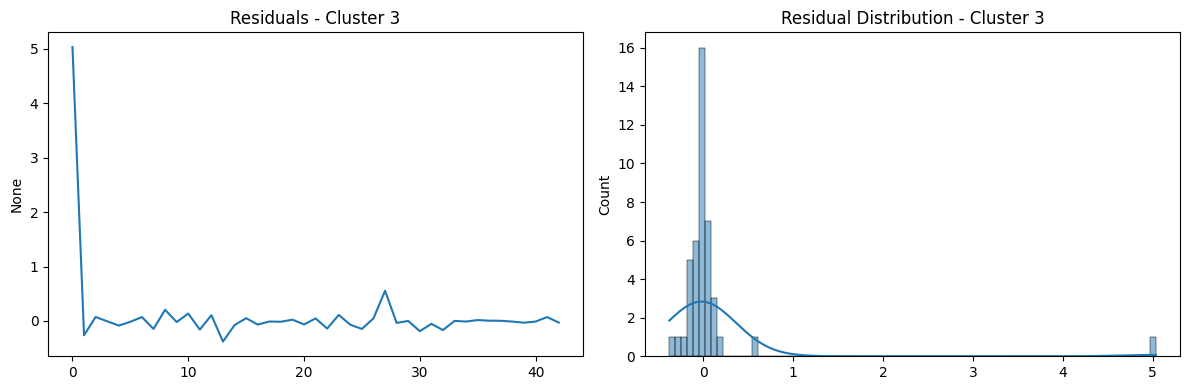

In [14]:
# --- Ambil data magnitudo untuk Cluster 3  ---

cluster_id = 3
cluster_data = mean_mag_df[mean_mag_df['cluster'] == cluster_id].sort_values(by='year')
ts = pd.Series(cluster_data['avg_mag'].values, 
               index=pd.period_range(start=str(cluster_data['year'].min()), 
                                     end=str(cluster_data['year'].max()), freq='Y'))

# --- ACF & PACF ---
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(ts, ax=ax[0])
plot_pacf(ts, ax=ax[1])
ax[0].set_title(f"ACF - Cluster {cluster_id}")
ax[1].set_title(f"PACF - Cluster {cluster_id}")
plt.tight_layout()
plt.show()

# --- ARIMA Fit & Forecast ---
model = ARIMA(ts, order=(0, 1, 0))  # atau ganti dengan results[cluster_id]['order']
fit = model.fit()
print(fit.summary())

forecast_index = pd.period_range(start=ts.index[0], end='2040', freq='Y')
pred = fit.predict(start=forecast_index[0], end=forecast_index[-1], typ='levels')

ts.plot(label="Actual", figsize=(10, 4))
pred.plot(label="Forecast")
plt.title(f"ARIMA Forecast - Cluster {cluster_id}")
plt.legend()
plt.show()

# --- Residual Diagnostic ---
resid = fit.resid
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(x=range(len(resid)), y=resid, ax=ax[0])
sns.histplot(resid, kde=True, ax=ax[1])
ax[0].set_title(f"Residuals - Cluster {cluster_id}")
ax[1].set_title(f"Residual Distribution - Cluster {cluster_id}")
plt.tight_layout()
plt.show()


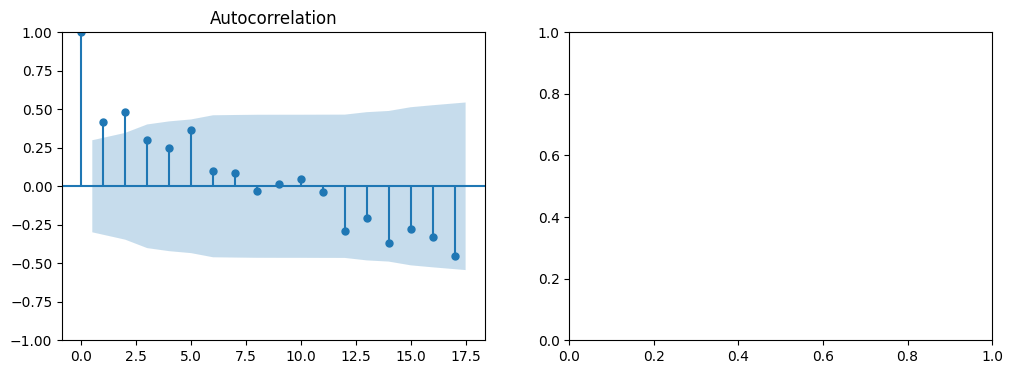

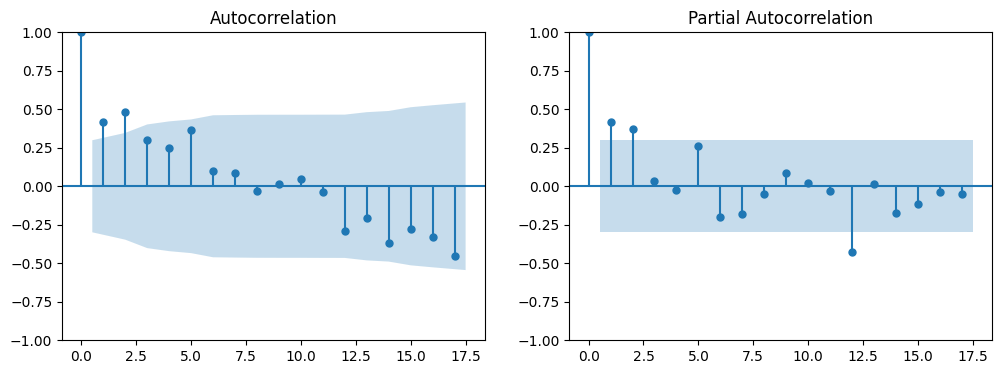

Text(0.5, 1.0, 'ACF - Cluster 4')

Text(0.5, 1.0, 'PACF - Cluster 4')

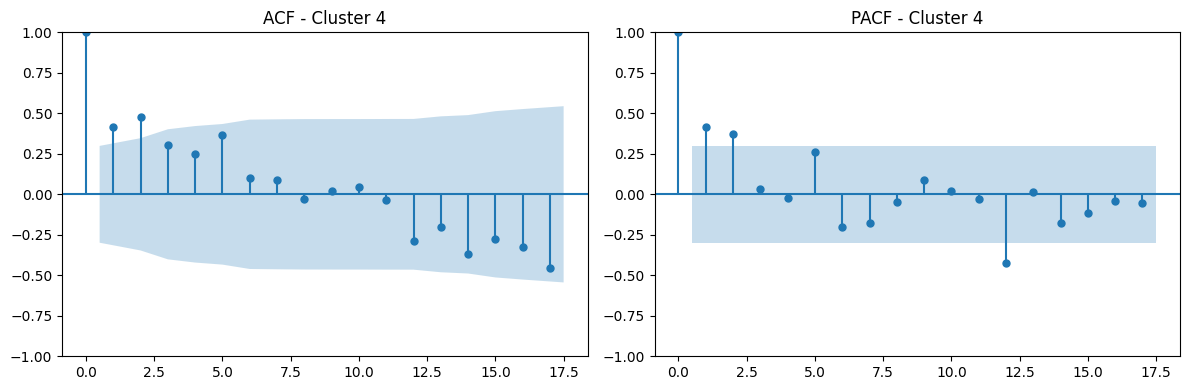

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   43
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  62.023
Date:                Sun, 20 Jul 2025   AIC                           -118.047
Time:                        14:34:43   BIC                           -112.834
Sample:                    12-31-1982   HQIC                          -116.136
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6372      0.199     -3.206      0.001      -1.027      -0.248
ar.L2         -0.1253      0.176     -0.712      0.476      -0.470       0.219
sigma2         0.0030      0.001      5.266      0.0

<Axes: >

<Axes: >

Text(0.5, 1.0, 'ARIMA Forecast - Cluster 4')

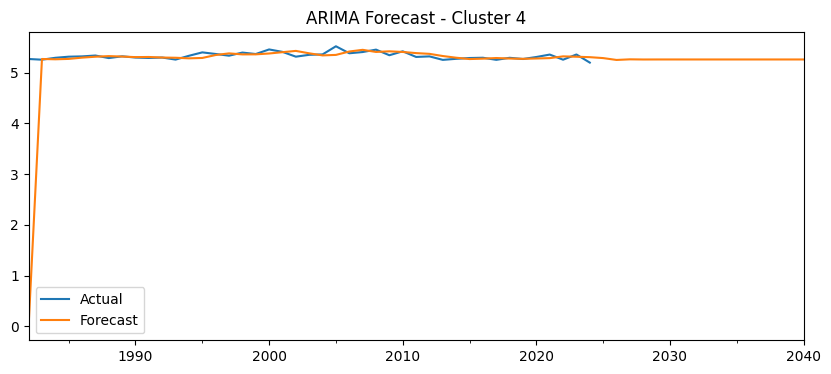

<Axes: ylabel='None'>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Residuals - Cluster 4')

Text(0.5, 1.0, 'Residual Distribution - Cluster 4')

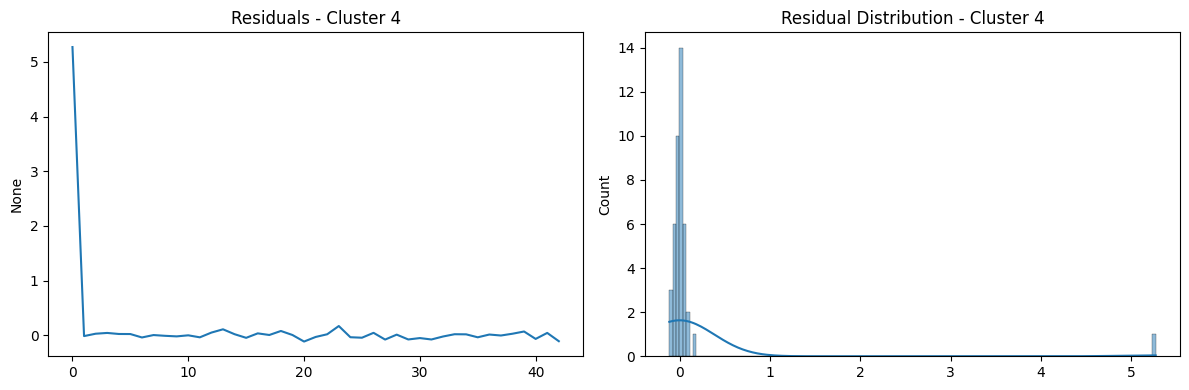

In [16]:
# --- Ambil data magnitudo untuk Cluster 4 ---

cluster_id = 4
cluster_data = mean_mag_df[mean_mag_df['cluster'] == cluster_id].sort_values(by='year')
ts = pd.Series(cluster_data['avg_mag'].values, 
               index=pd.period_range(start=str(cluster_data['year'].min()), 
                                     end=str(cluster_data['year'].max()), freq='Y'))

# --- ACF & PACF ---
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(ts, ax=ax[0])
plot_pacf(ts, ax=ax[1])
ax[0].set_title(f"ACF - Cluster {cluster_id}")
ax[1].set_title(f"PACF - Cluster {cluster_id}")
plt.tight_layout()
plt.show()

# --- ARIMA Fit & Forecast ---
model = ARIMA(ts, order=(2, 1, 0))  # atau ganti dengan results[cluster_id]['order']
fit = model.fit()
print(fit.summary())

forecast_index = pd.period_range(start=ts.index[0], end='2040', freq='Y')
pred = fit.predict(start=forecast_index[0], end=forecast_index[-1], typ='levels')

ts.plot(label="Actual", figsize=(10, 4))
pred.plot(label="Forecast")
plt.title(f"ARIMA Forecast - Cluster {cluster_id}")
plt.legend()
plt.show()

# --- Residual Diagnostic ---
resid = fit.resid
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(x=range(len(resid)), y=resid, ax=ax[0])
sns.histplot(resid, kde=True, ax=ax[1])
ax[0].set_title(f"Residuals - Cluster {cluster_id}")
ax[1].set_title(f"Residual Distribution - Cluster {cluster_id}")
plt.tight_layout()
plt.show()



--- Cluster 0 ---


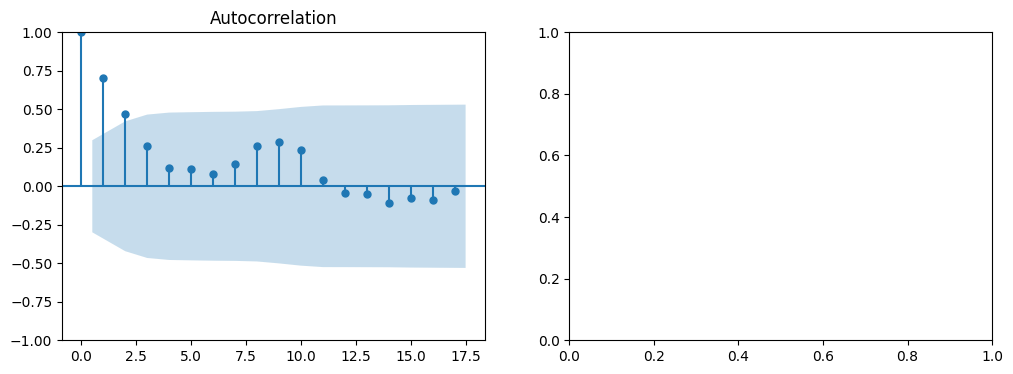

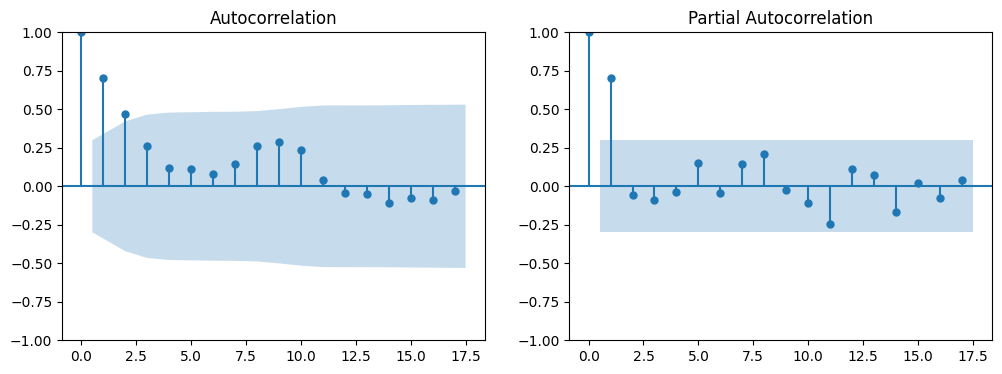

Text(0.5, 1.0, 'ACF - Cluster 0')

Text(0.5, 1.0, 'PACF - Cluster 0')

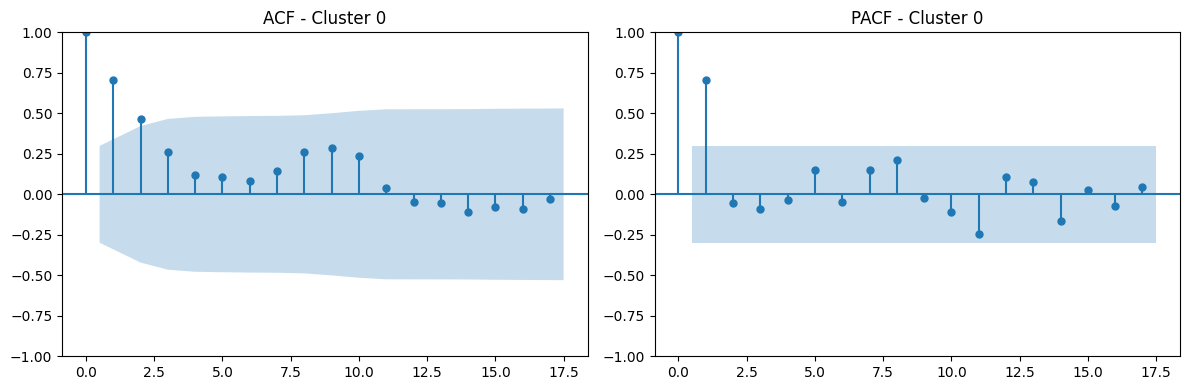

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   43
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  46.228
Date:                Sun, 20 Jul 2025   AIC                            -90.457
Time:                        14:44:39   BIC                            -88.719
Sample:                    12-31-1982   HQIC                           -89.820
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0065      0.001      7.840      0.000       0.005       0.008
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                34.07
Prob(Q):                              0.59   Pr

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Prediksi Rata-rata Magnitudo per Tahun (Cluster 0 - ARIMA Forecast)')

Text(0.5, 0, 'Tahun')

Text(0, 0.5, 'Magnitudo')

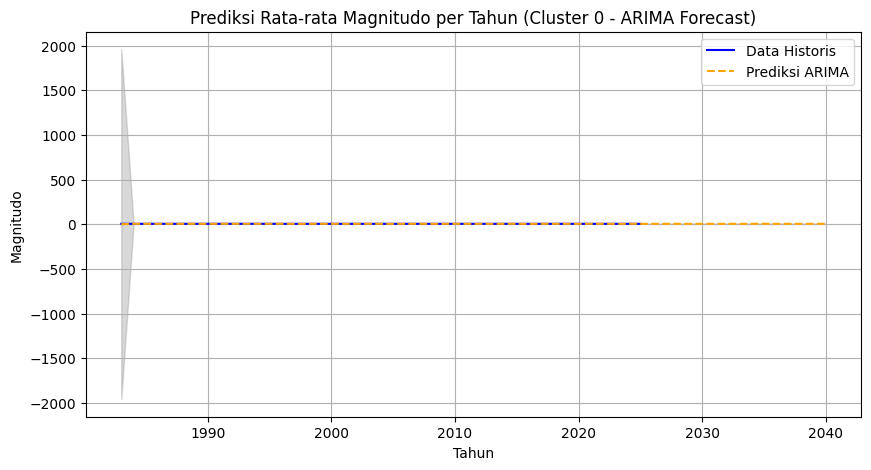

<Axes: ylabel='None'>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Residuals - Cluster 0')

Text(0.5, 1.0, 'Residual Distribution - Cluster 0')

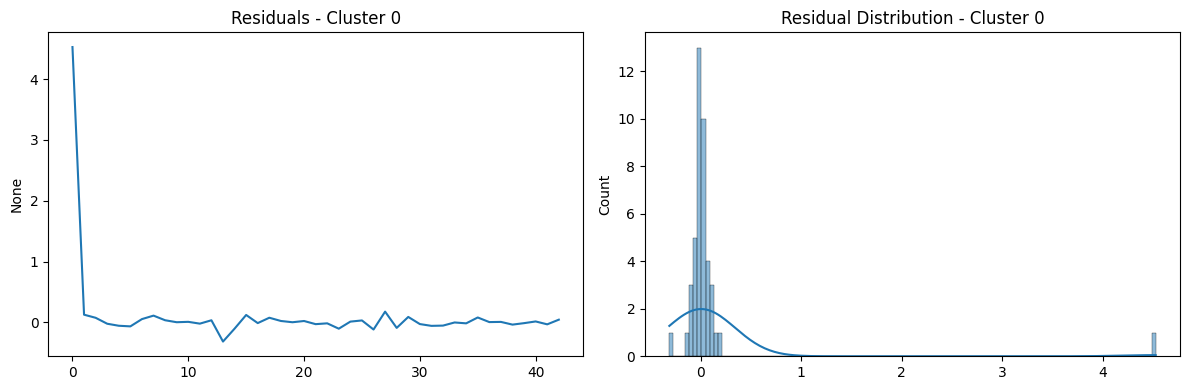


--- Cluster 1 ---


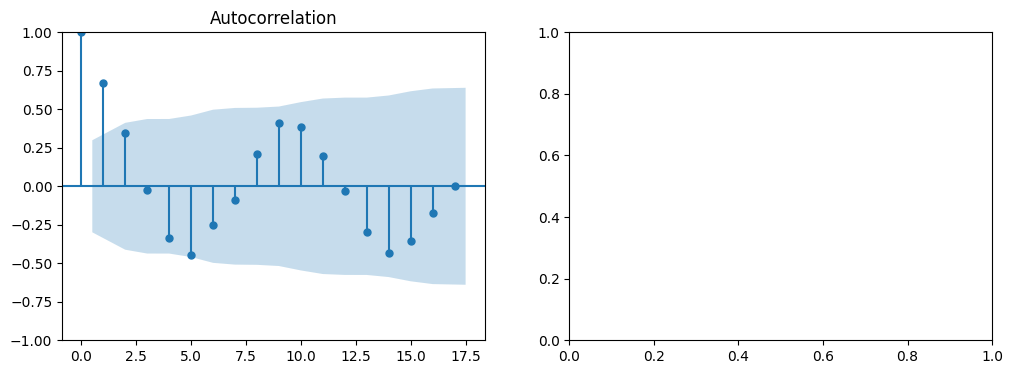

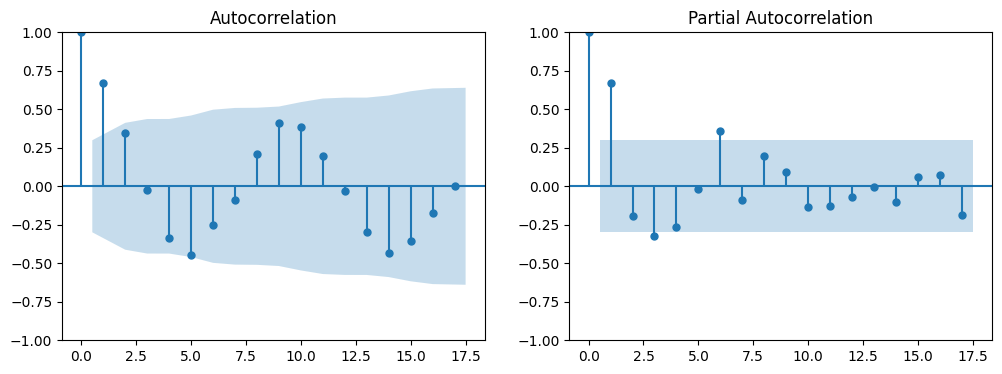

Text(0.5, 1.0, 'ACF - Cluster 1')

Text(0.5, 1.0, 'PACF - Cluster 1')

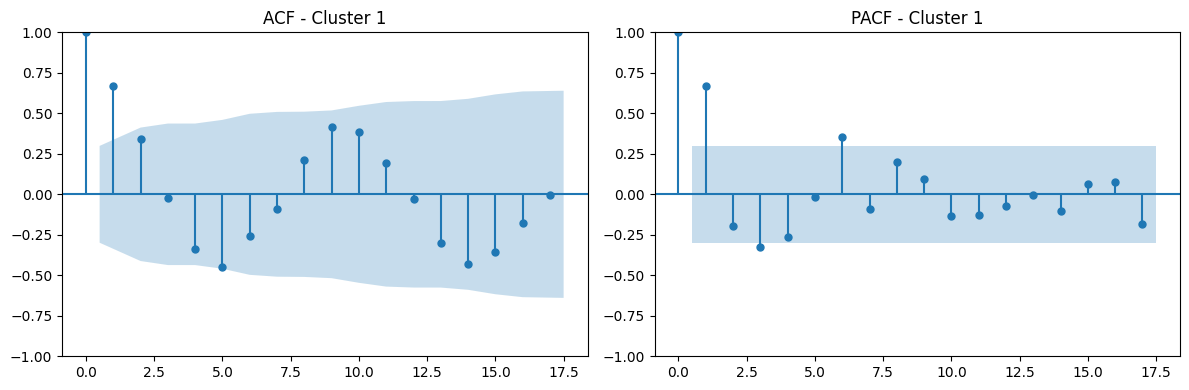

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   43
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  51.979
Date:                Sun, 20 Jul 2025   AIC                            -97.958
Time:                        14:44:41   BIC                            -92.674
Sample:                    12-31-1982   HQIC                           -96.009
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3673      0.033    134.064      0.000       4.303       4.431
ar.L1          0.6738      0.108      6.217      0.000       0.461       0.886
sigma2         0.0051      0.001      4.948      0.0

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Prediksi Rata-rata Magnitudo per Tahun (Cluster 1 - ARIMA Forecast)')

Text(0.5, 0, 'Tahun')

Text(0, 0.5, 'Magnitudo')

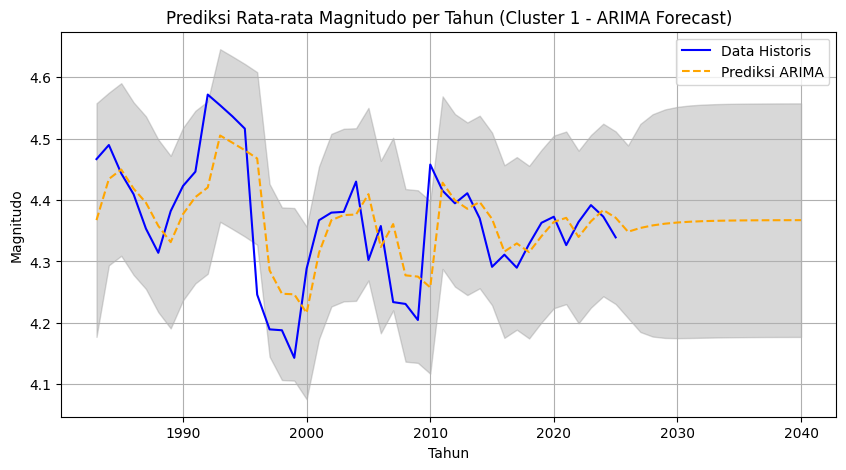

<Axes: ylabel='None'>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Residuals - Cluster 1')

Text(0.5, 1.0, 'Residual Distribution - Cluster 1')

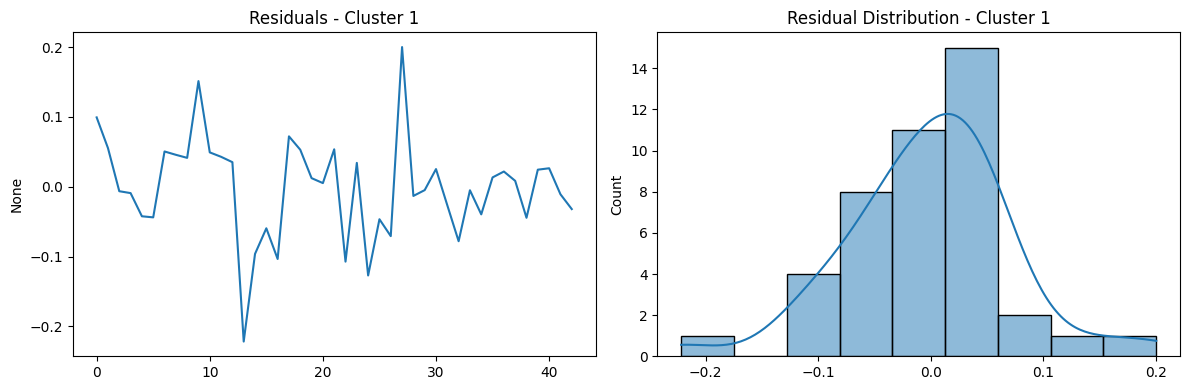


--- Cluster 2 ---


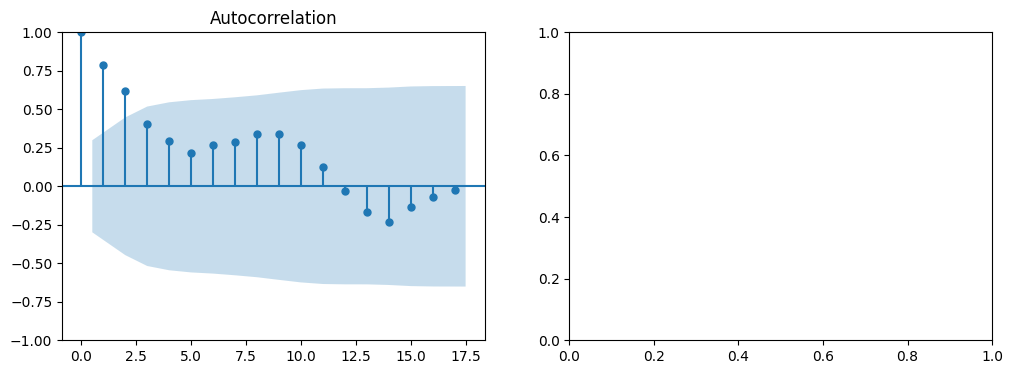

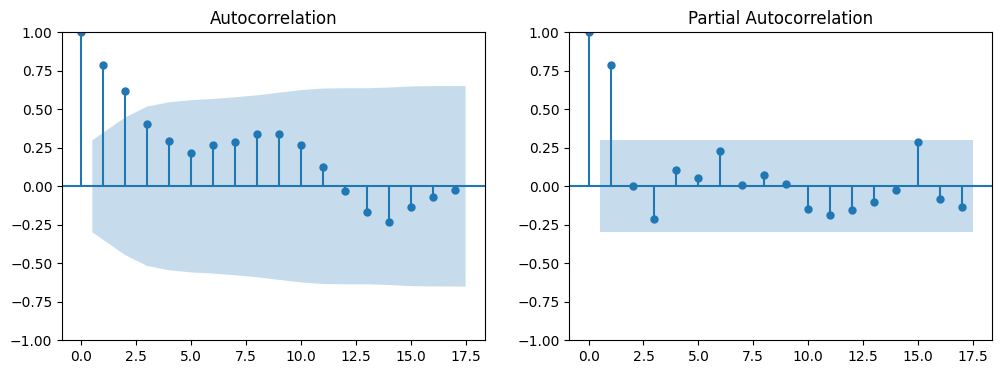

Text(0.5, 1.0, 'ACF - Cluster 2')

Text(0.5, 1.0, 'PACF - Cluster 2')

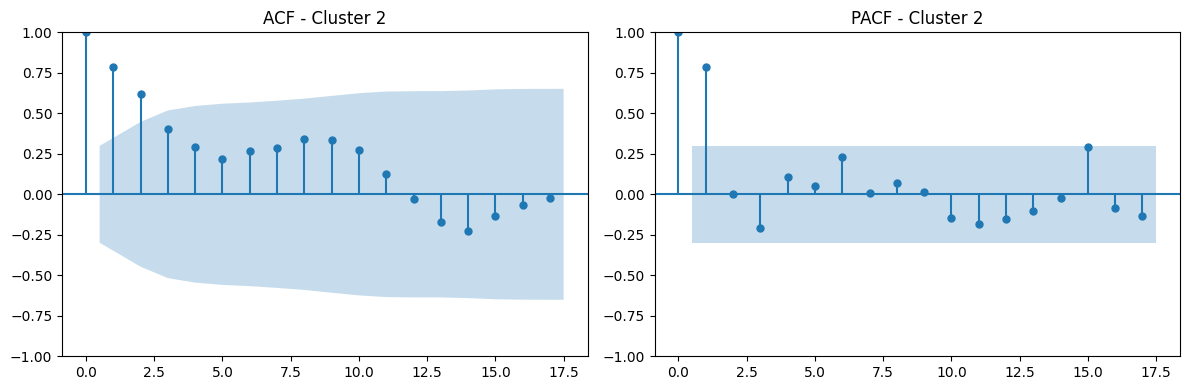

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   43
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  50.267
Date:                Sun, 20 Jul 2025   AIC                            -98.533
Time:                        14:44:42   BIC                            -96.795
Sample:                    12-31-1982   HQIC                           -97.896
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0053      0.000     11.112      0.000       0.004       0.006
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):               171.18
Prob(Q):                              0.34   Pr

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Prediksi Rata-rata Magnitudo per Tahun (Cluster 2 - ARIMA Forecast)')

Text(0.5, 0, 'Tahun')

Text(0, 0.5, 'Magnitudo')

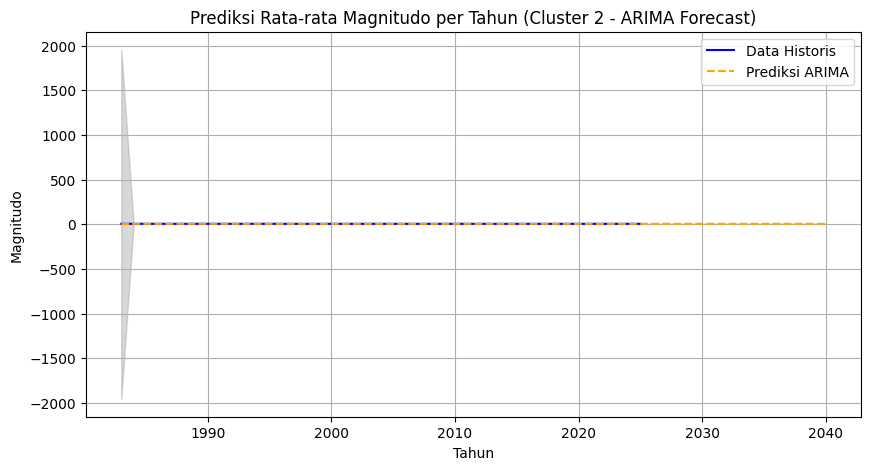

<Axes: ylabel='None'>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Residuals - Cluster 2')

Text(0.5, 1.0, 'Residual Distribution - Cluster 2')

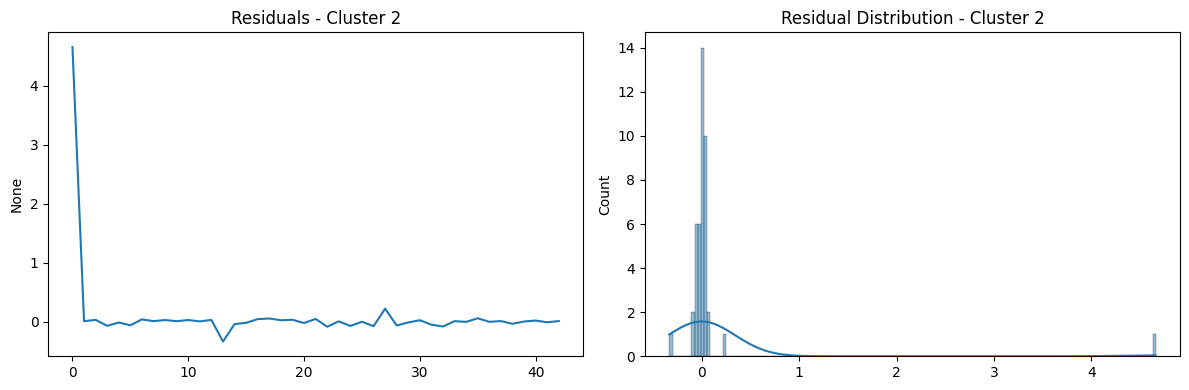


--- Cluster 3 ---


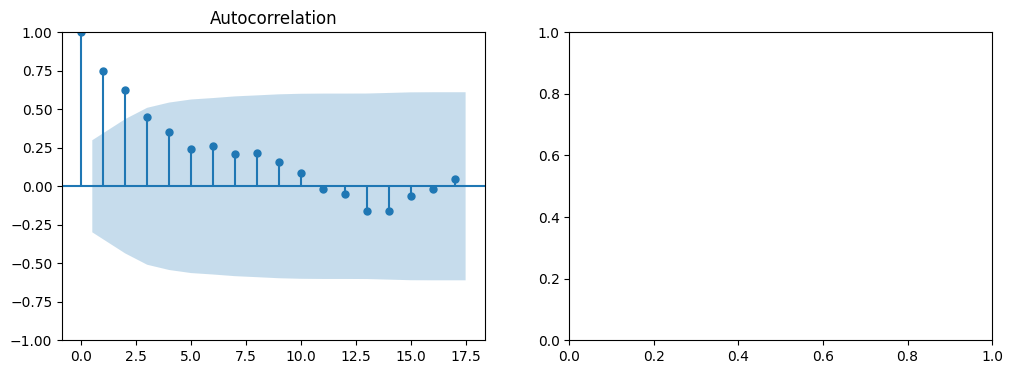

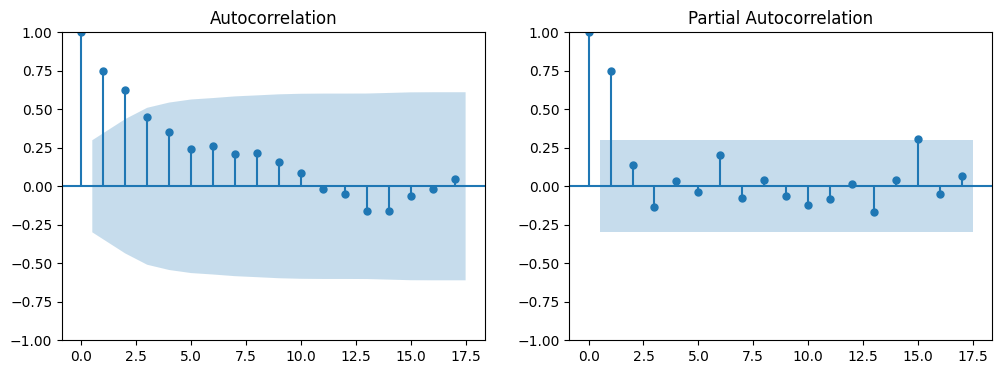

Text(0.5, 1.0, 'ACF - Cluster 3')

Text(0.5, 1.0, 'PACF - Cluster 3')

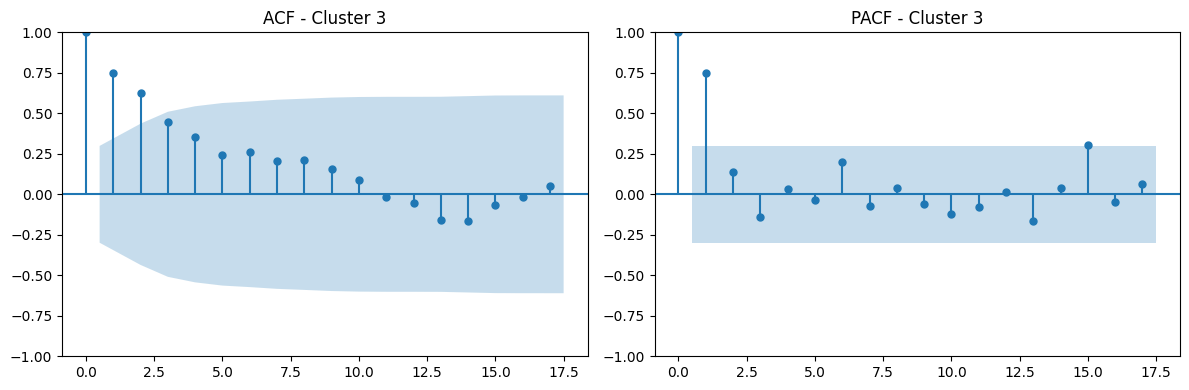

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   43
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  23.262
Date:                Sun, 20 Jul 2025   AIC                            -44.523
Time:                        14:44:44   BIC                            -42.786
Sample:                    12-31-1982   HQIC                           -43.886
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0193      0.002      8.608      0.000       0.015       0.024
Ljung-Box (L1) (Q):                   1.33   Jarque-Bera (JB):                66.02
Prob(Q):                              0.25   Pr

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Prediksi Rata-rata Magnitudo per Tahun (Cluster 3 - ARIMA Forecast)')

Text(0.5, 0, 'Tahun')

Text(0, 0.5, 'Magnitudo')

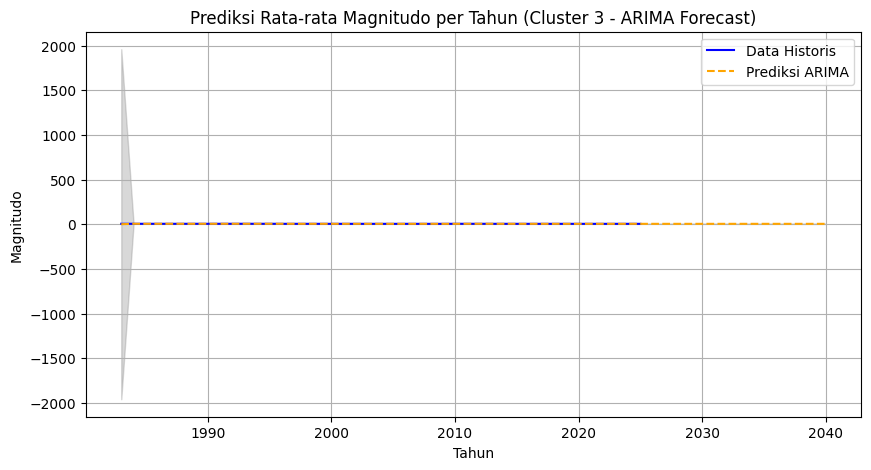

<Axes: ylabel='None'>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Residuals - Cluster 3')

Text(0.5, 1.0, 'Residual Distribution - Cluster 3')

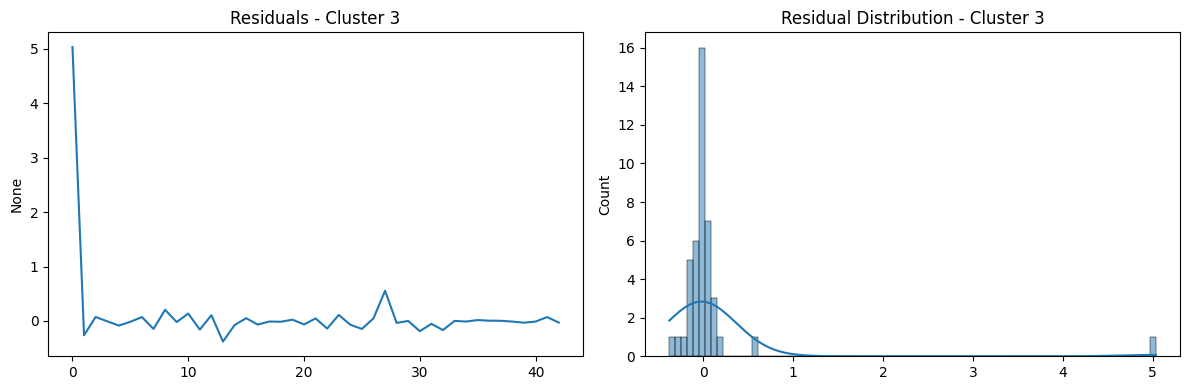


--- Cluster 4 ---


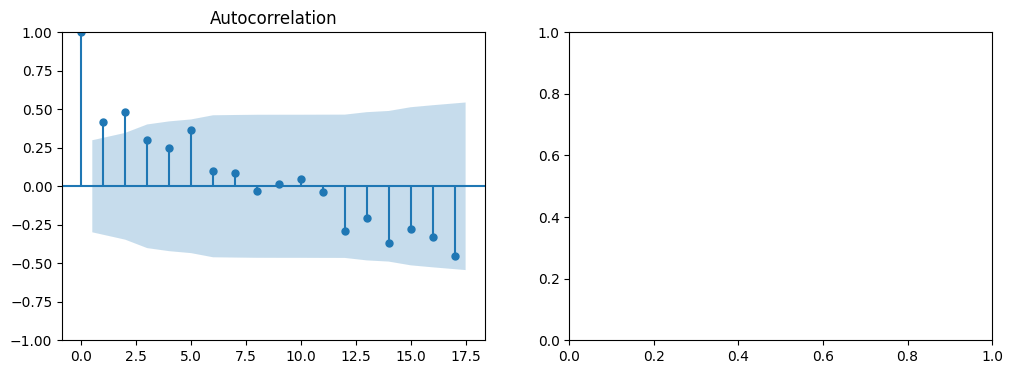

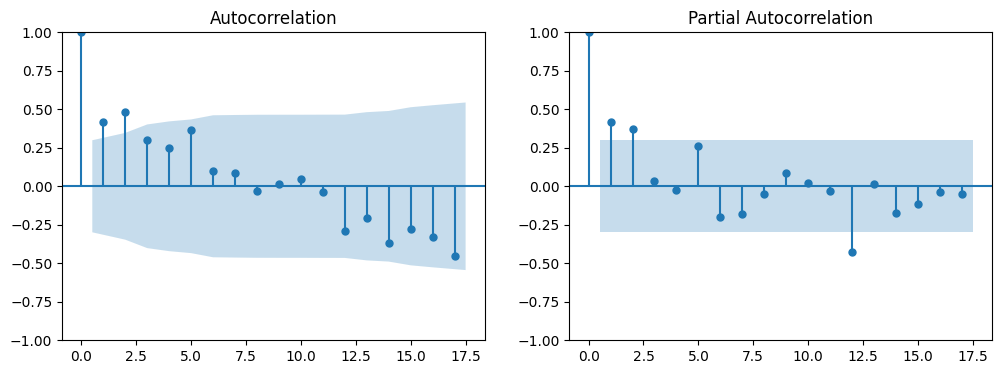

Text(0.5, 1.0, 'ACF - Cluster 4')

Text(0.5, 1.0, 'PACF - Cluster 4')

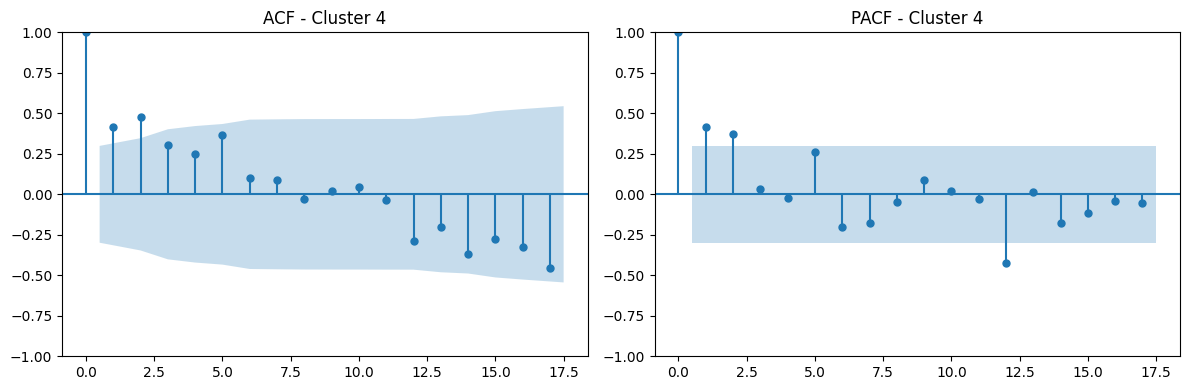

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   43
Model:                 ARIMA(2, 0, 0)   Log Likelihood                  65.354
Date:                Sun, 20 Jul 2025   AIC                           -122.707
Time:                        14:44:46   BIC                           -115.662
Sample:                    12-31-1982   HQIC                          -120.109
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3218      0.032    164.411      0.000       5.258       5.385
ar.L1          0.2632      0.225      1.168      0.243      -0.179       0.705
ar.L2          0.4167      0.163      2.553      0.0

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Prediksi Rata-rata Magnitudo per Tahun (Cluster 4 - ARIMA Forecast)')

Text(0.5, 0, 'Tahun')

Text(0, 0.5, 'Magnitudo')

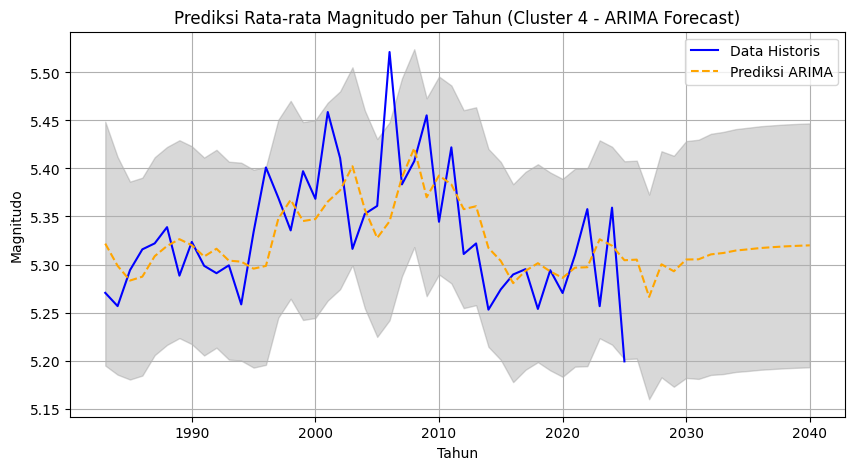

<Axes: ylabel='None'>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Residuals - Cluster 4')

Text(0.5, 1.0, 'Residual Distribution - Cluster 4')

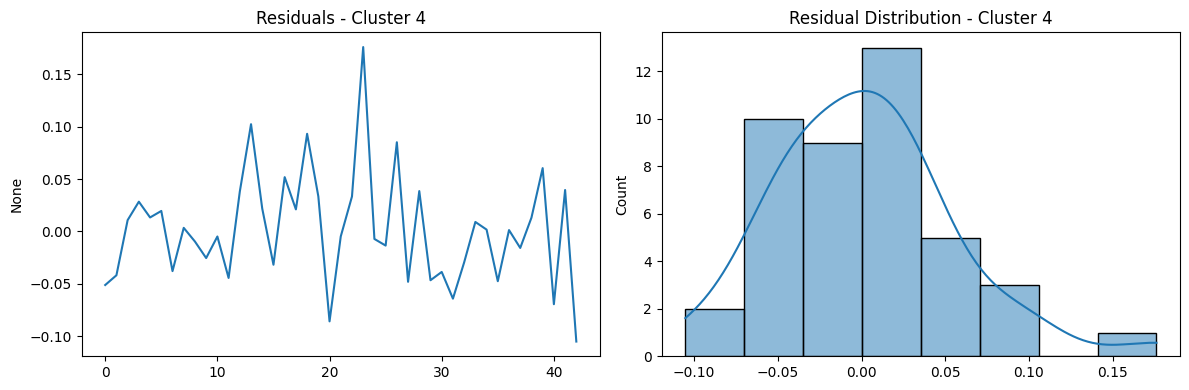

In [22]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Ganti sesuai hasil analisis order ARIMA masing-masing cluster
arima_orders = {
    0: (0, 1, 0),
    1: (1, 0, 0),
    2: (0, 1, 0),
    3: (0, 1, 0),
    4: (2, 0, 0)
}

for cluster_id in range(5):
    print(f"\n--- Cluster {cluster_id} ---")
    
    # 1. Ambil data per cluster
    cluster_data = mean_mag_df[mean_mag_df['cluster'] == cluster_id].sort_values(by='year')
    ts = pd.Series(cluster_data['avg_mag'].values,
               index=pd.date_range(start=f"{cluster_data['year'].min()}",
                                   periods=len(cluster_data), freq='Y'))


    # 2. ACF & PACF
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(ts, ax=ax[0])
    plot_pacf(ts, ax=ax[1])
    ax[0].set_title(f"ACF - Cluster {cluster_id}")
    ax[1].set_title(f"PACF - Cluster {cluster_id}")
    plt.tight_layout()
    plt.show()

    # 3. Fit ARIMA
    order = arima_orders[cluster_id]
    model = ARIMA(ts, order=order)
    fit = model.fit()
    print(fit.summary())

    # 4. Forecast
    forecast_years = pd.date_range(start=ts.index[0], end='2040', freq='Y')
    pred = fit.get_prediction(start=forecast_years[0], end=forecast_years[-1])
    pred_mean = pred.predicted_mean
    conf_int = pred.conf_int()

    # 5. Plot Forecast dengan CI
    plt.figure(figsize=(10, 5))
    plt.plot(ts, label="Data Historis", color="blue")
    plt.plot(pred_mean, label="Prediksi ARIMA", linestyle="--", color="orange")
    plt.fill_between(conf_int.index, 
                     conf_int.iloc[:, 0], 
                     conf_int.iloc[:, 1], 
                     color='gray', alpha=0.3)
    plt.title(f"Prediksi Rata-rata Magnitudo per Tahun (Cluster {cluster_id} - ARIMA Forecast)")
    plt.xlabel("Tahun")
    plt.ylabel("Magnitudo")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 6. Residual Diagnostic
    resid = fit.resid
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.lineplot(x=range(len(resid)), y=resid, ax=ax[0])
    sns.histplot(resid, kde=True, ax=ax[1])
    ax[0].set_title(f"Residuals - Cluster {cluster_id}")
    ax[1].set_title(f"Residual Distribution - Cluster {cluster_id}")
    plt.tight_layout()
    plt.show()


In [23]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# --- 1. Load dataset hasil clustering ---
df = pd.read_csv("seismic_gap_features_clustered.csv")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# --- 2. Hitung rata-rata magnitudo per tahun per cluster ---
mean_mag_df = df.groupby(['year', 'cluster'])['mag'].mean().reset_index(name='avg_mag')

# --- 3. Order ARIMA berdasarkan hasil analisis sebelumnya ---
arima_orders = {
    0: (0, 1, 0),
    1: (1, 0, 0),
    2: (0, 1, 0),
    3: (0, 1, 0),
    4: (2, 0, 0)
}

# --- 4. Forecast tiap cluster 2025–2040 ---
forecast_all = pd.DataFrame()

for cluster_id in range(5):
    cluster_data = mean_mag_df[mean_mag_df['cluster'] == cluster_id].sort_values(by='year')

    ts = pd.Series(cluster_data['avg_mag'].values,
                   index=pd.date_range(start=f"{cluster_data['year'].min()}",
                                       periods=len(cluster_data), freq='Y'))

    order = arima_orders[cluster_id]
    model = ARIMA(ts, order=order)
    fit = model.fit()

    # Buat indeks forecast dari 2025 sampai 2040
    forecast_index = pd.date_range(start="2025", end="2040", freq="Y")
    steps = len(forecast_index)
    forecast = fit.forecast(steps=steps)

    # Simpan hasil ke DataFrame
    df_forecast = pd.DataFrame({
        'year': forecast_index.year,
        f'cluster_{cluster_id}': forecast.values
    })

    if forecast_all.empty:
        forecast_all = df_forecast
    else:
        forecast_all = forecast_all.merge(df_forecast, on='year', how='outer')

# --- 5. Simpan ke Excel ---
forecast_all.to_excel("forecast_magnitudo_2025_2040.xlsx", index=False)
print("✅ Forecast saved to 'forecast_magnitudo_2025_2040.xlsx'")


✅ Forecast saved to 'forecast_magnitudo_2025_2040.xlsx'


B. Forecasting dengan Prophet

In [ ]:
from prophet import Prophet

In [ ]:
#cluster 0

cluster_id = 0
ts = cluster_counts[cluster_id]

# --- Siapkan data untuk Prophet ---
df_p = ts.reset_index()
df_p.columns = ['ds', 'y']

# --- Fit Prophet ---
model_p = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
model_p.fit(df_p)

# --- Buat data masa depan dan prediksi ---
future = model_p.make_future_dataframe(periods=2040 - df_p['ds'].dt.year.max(), freq='Y')
forecast = model_p.predict(future)

# --- Plot hasil prediksi ---
fig = model_p.plot(forecast)
plt.title(f"Prophet Forecast - Cluster {cluster_id}")
plt.show()

# --- Residual Diagnostic ---
# Hanya nilai historis sampai 2024 yang dibandingkan
y_true = df_p['y']
y_pred = forecast.loc[forecast['ds'] < '2025-01-01', 'yhat']
resid_p = y_true.values - y_pred.values

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(x=range(len(resid_p)), y=resid_p, ax=ax[0])
sns.histplot(resid_p, kde=True, ax=ax[1])
ax[0].set_title(f"Residuals - Prophet Cluster {cluster_id}")
ax[1].set_title(f"Residual Distribution - Prophet Cluster {cluster_id}")
plt.tight_layout()
plt.show()


In [ ]:
#cluster 1

cluster_id = 1
ts = cluster_counts[cluster_id]

# --- Siapkan data untuk Prophet ---
df_p = ts.reset_index()
df_p.columns = ['ds', 'y']

# --- Fit Prophet ---
model_p = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
model_p.fit(df_p)

# --- Buat data masa depan dan prediksi ---
future = model_p.make_future_dataframe(periods=2040 - df_p['ds'].dt.year.max(), freq='Y')
forecast = model_p.predict(future)

# --- Plot hasil prediksi ---
fig = model_p.plot(forecast)
plt.title(f"Prophet Forecast - Cluster {cluster_id}")
plt.show()

# --- Residual Diagnostic ---
# Hanya nilai historis sampai 2024 yang dibandingkan
y_true = df_p['y']
y_pred = forecast.loc[forecast['ds'] < '2025-01-01', 'yhat']
resid_p = y_true.values - y_pred.values

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(x=range(len(resid_p)), y=resid_p, ax=ax[0])
sns.histplot(resid_p, kde=True, ax=ax[1])
ax[0].set_title(f"Residuals - Prophet Cluster {cluster_id}")
ax[1].set_title(f"Residual Distribution - Prophet Cluster {cluster_id}")
plt.tight_layout()
plt.show()


In [ ]:
#cluster 2

cluster_id = 2
ts = cluster_counts[cluster_id]

# --- Siapkan data untuk Prophet ---
df_p = ts.reset_index()
df_p.columns = ['ds', 'y']

# --- Fit Prophet ---
model_p = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
model_p.fit(df_p)

# --- Buat data masa depan dan prediksi ---
future = model_p.make_future_dataframe(periods=2040 - df_p['ds'].dt.year.max(), freq='Y')
forecast = model_p.predict(future)

# --- Plot hasil prediksi ---
fig = model_p.plot(forecast)
plt.title(f"Prophet Forecast - Cluster {cluster_id}")
plt.show()

# --- Residual Diagnostic ---
# Hanya nilai historis sampai 2024 yang dibandingkan
y_true = df_p['y']
y_pred = forecast.loc[forecast['ds'] < '2025-01-01', 'yhat']
resid_p = y_true.values - y_pred.values

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(x=range(len(resid_p)), y=resid_p, ax=ax[0])
sns.histplot(resid_p, kde=True, ax=ax[1])
ax[0].set_title(f"Residuals - Prophet Cluster {cluster_id}")
ax[1].set_title(f"Residual Distribution - Prophet Cluster {cluster_id}")
plt.tight_layout()
plt.show()


In [ ]:
# 🔵 Cluster 0 – Komponen Prophet
# Trend: Menurun perlahan

# Prophet mengidentifikasi penurunan jangka panjang pada jumlah gempa di cluster ini

# Konsisten dengan prediksi menurun yang terlihat di forecast plot sebelumnya

# Seasonality: Fluktuasi tahunan jelas, dengan puncak sekitar awal & akhir tahun

# Bisa menunjukkan pola laporan musiman atau pengaruh geofisika seperti cuaca, musim, atau waktu pelaporan

# 🟠 Cluster 1 – Komponen Prophet
# Trend: Naik konsisten dari tahun ke tahun

# Prophet mengkonfirmasi bahwa gempa dalam (mungkin dari subduksi) meningkat secara stabil

# Seasonality: Ada siklus tahunan ringan

# Tapi osilasinya relatif kecil → Prophet mendeteksi pola tetapi tidak dominan

# 🟢 Cluster 2 – Komponen Prophet
# Trend: Sangat kuat naik

# Kenaikan tajam ini sesuai dengan tren jumlah gempa kecil dangkal yang meningkat (kemungkinan juga karena peralatan pendeteksi makin sensitif)

# Seasonality: Fluktuasi besar dan tajam

# Prophet menganggap pola tahunan sangat signifikan di sini → penting untuk dilihat lebih lanjut (mungkin cluster ini rawan terhadap siklus musiman geologi)

# 🧠 Kesimpulan Umum:
# Cluster	Trend Prophet	Musiman (Yearly)	Implikasi
# 0	Menurun	Kuat	Mungkin puncak hanya di musim tertentu
# 1	Naik stabil	Ringan	Kenaikan stabil tahunan, aman
# 2	Naik tajam	Sangat kuat	Perlu monitoring musiman & tren jangka panjang